In [1]:
!pip install --upgrade pip
!pip install tensorflow_addons
!pip install seaborn
!pip install transformers
!pip install scikit-learn
!pip install imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.8 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow_addons as tfa

from transformers import TFAutoModel, AutoTokenizer


from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional, LSTM, Flatten,GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from transformers import TFRobertaModel
from keras.models import load_model
from keras.utils import CustomObjectScope

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you 

* Đọc dữ liệu

In [2]:
df = pd.read_csv('/Users/datnguyen/Documents/hoc_truong/project/NLP/Nhom_10/data/data.tsv',sep='\t')
df.head()

,comment,rating_star,khia_canh
0,mô tả sai 60 cửa hàng giao bao nhiêu bẻ 50 nhắ...,negative,"Chất lượng sản phẩm, Dịch vụ khách hàng, Giao ..."
1,sản phẩm cửa hàng hài sản phẩm hàng hơi lâu4 ủ...,negative,Dịch vụ khách hàng
2,giao hàng cửa hàng thèm phục vụ kém nhắn đợi t...,negative,"Chất lượng sản phẩm, Dịch vụ khách hàng, Giao ..."
3,chất sản phẩm tệ hại y cửa hàng hàng khuyên cử...,negative,"Chất lượng sản phẩm, Dịch vụ khách hàng, Giao ..."
4,sản phẩm giao cửa hàng phục vụ nhiệt tình 2 sả...,negative,"Dịch vụ khách hàng, Giao hàng"


* Chọn dữ liệu

In [3]:
X = df.comment
y = df.rating_star

* LabelEncoder

In [4]:
le_rating = LabelEncoder()

In [5]:
MAX_LEN = 200
model_name = 'vinai/phobert-base'

# Tokenizing
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoded_inputs = tokenizer.batch_encode_plus(
    df.comment.tolist(), 
    max_length=MAX_LEN, 
    padding='max_length', 
    truncation=True,
    return_tensors='np'
)

In [6]:
X = encoded_inputs['input_ids']
y = le_rating.fit_transform(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2006)

* TPU setup

In [8]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

Number of replicas: 1


In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict())
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


2023-12-05 08:57:32.857919: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-05 08:57:32.857983: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-05 08:57:32.857992: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-05 08:57:32.858021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-05 08:57:32.858035: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


* OnehotEncoder

In [10]:
y_train = tf.keras.utils.to_categorical(y_train)

* Build Model

In [11]:
with strategy.scope():
    encoder = TFAutoModel.from_pretrained(model_name)

    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32)

    # Extract features with phoBert
    embedding = encoder(input_ids)[0]

    # Add LSTM layer
    lstm_layer = LSTM(units=64, return_sequences=True)(embedding)

    # Add CNN layers after LSTM
    cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(lstm_layer)
    cnn_layer = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_layer)
    cnn_layer = BatchNormalization()(cnn_layer)

    # Flatten or pool the output of the CNN if necessary
    # Depending on your data, you might need a GlobalMaxPooling1D or Flatten layer here
    cnn_output = GlobalMaxPooling1D()(cnn_layer)

    x = Dense(256, activation='relu', kernel_regularizer=regularizers.L2(0.1))(cnn_output)
    x = Dropout(0.2)(x)

    # Output layer
    output = Dense(y_train.shape[1], activation='softmax', name='output')(x)

    # Create model
    model_rating = Model(inputs=input_ids, outputs=output)


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [12]:
model_rating.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPo   134998272 
 aModel)                     olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 200, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                             

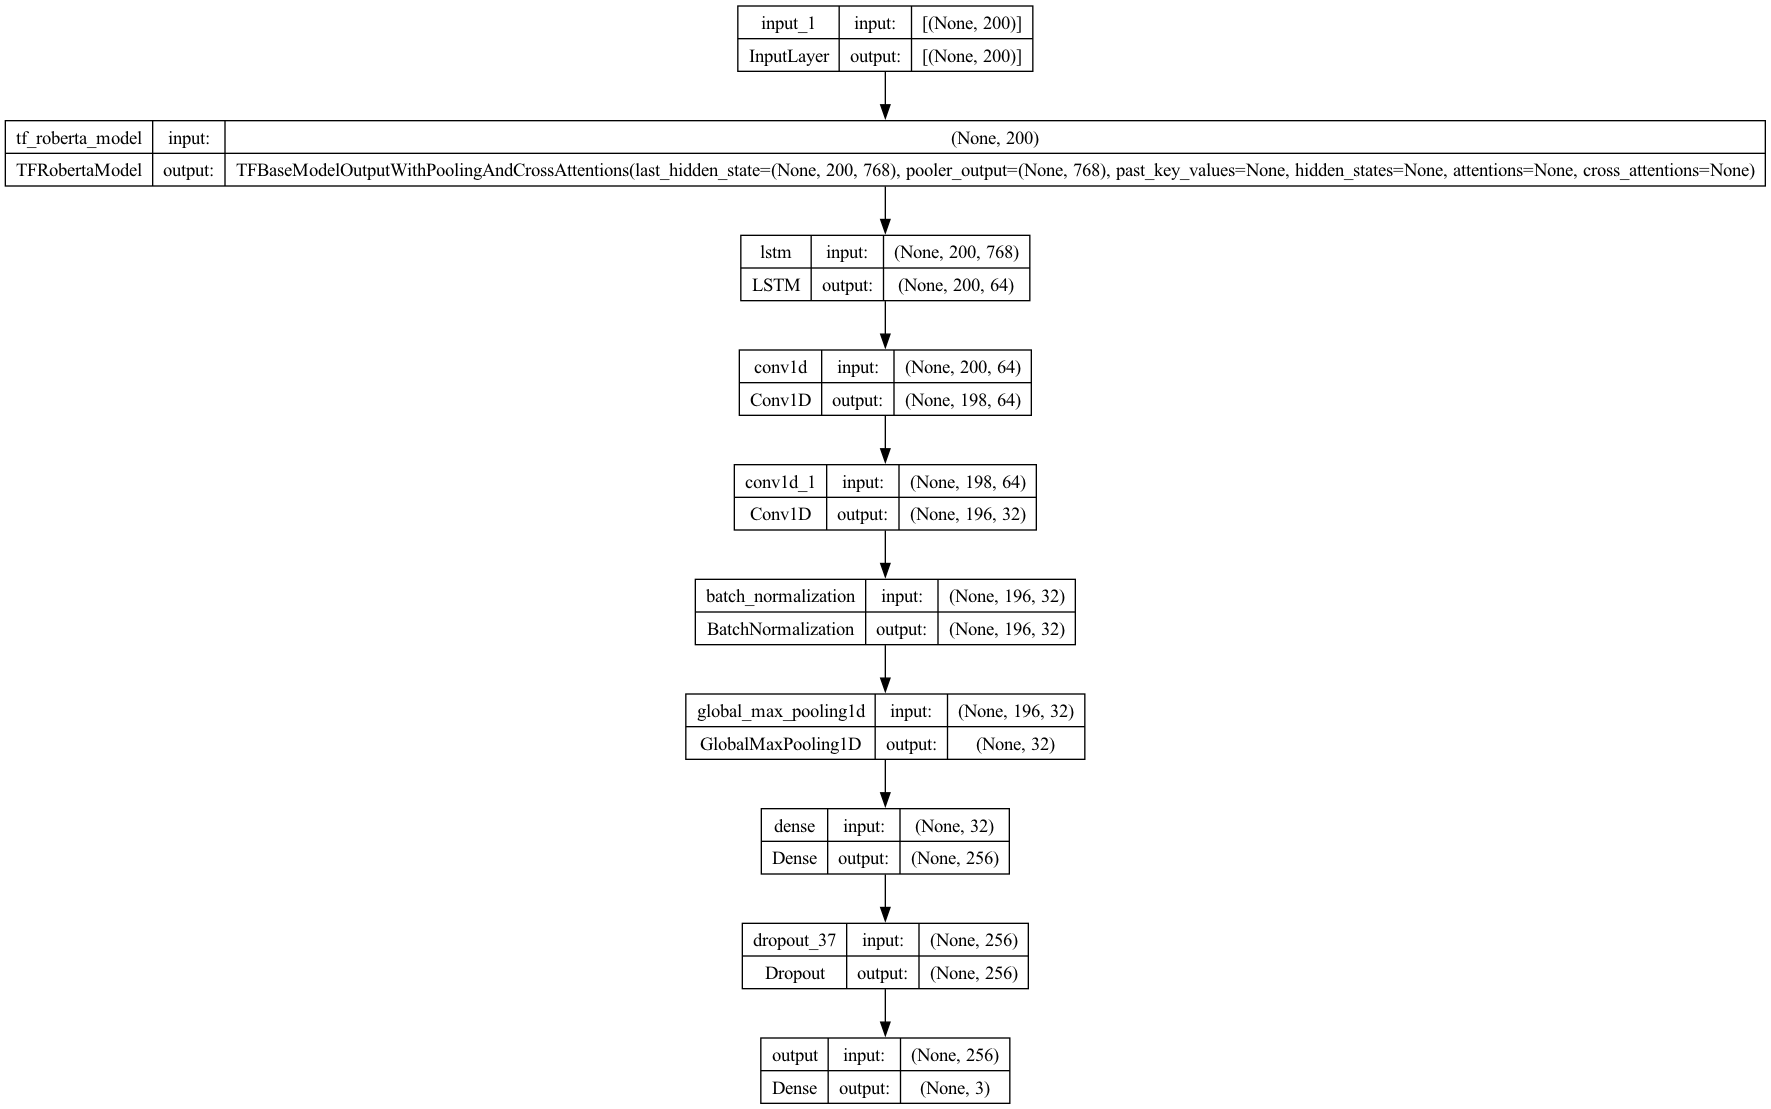

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model_rating, to_file='model_rating.png', show_shapes=True, show_layer_names=True)

* Optimize

In [17]:
class MyExponentialDecay(tf.keras.optimizers.schedules.ExponentialDecay):
  def __call__(self, step):
    return 1e-2 * super().__call__(step)

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-3, 1e-4, 1e-5])

initial_learning_rate=0.01

wd = MyExponentialDecay(
    initial_learning_rate,
    decay_steps=14,
    decay_rate=0.8,
    staircase=True)
lr = 1e2 * schedule(step)

In [18]:
model_rating.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=wd,
                                  learning_rate=lr),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])


In [19]:
# Lưu mô hình tốt nhất
cp_callback = ModelCheckpoint(filepath='pho_rating.h5',
                              save_best_only=True,
                              monitor='accuracy',
                              mode='max',
                              verbose=1)

# Dừng sớm khi không có quá nhiều thay đổi
es_callback = EarlyStopping(
    monitor='accuracy', 
    patience=15,
    mode='max')

In [20]:
# Setup tham số
epochs = 30
batch_size = 512
validation_split = 0.2

* Training

In [21]:
# Sử dụng dữ liệu đã resample để train mô hình
history = model_rating.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_split=validation_split,
    batch_size=batch_size,
    callbacks=[cp_callback, es_callback],
    verbose=1)


Epoch 1/30


2023-11-25 00:48:00.316101: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:00.333430: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:00.350637: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:00.368556: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:00.385626: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:00.403164: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:00.420875: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

2023-11-25 00:48:49.753245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AdamW/AssignAddVariableOp.
2023-11-25 00:48:54.180183: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:54.183536: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:54.183745: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:54.184035: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:54.184166: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:48:54.184443: E ./tensorflow/compiler/xla/stream_exec

  1/702 [..............................] - ETA: 22:00:16 - loss: 7.2053 - accuracy: 0.3594

2023-11-25 00:49:53.458233: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  2/702 [..............................] - ETA: 5:26 - loss: 16.2294 - accuracy: 0.5420   

2023-11-25 00:49:53.924170: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 11/702 [..............................] - ETA: 5:23 - loss: 13.4909 - accuracy: 0.4673

2023-11-25 00:49:58.147201: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 22/702 [..............................] - ETA: 5:17 - loss: 11.0349 - accuracy: 0.5123

2023-11-25 00:50:03.257594: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 44/702 [>.............................] - ETA: 5:05 - loss: 7.1973 - accuracy: 0.6006

2023-11-25 00:50:13.442210: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 66/702 [=>............................] - ETA: 4:55 - loss: 5.2386 - accuracy: 0.6334

2023-11-25 00:50:23.614523: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


143/702 [=====>........................] - ETA: 4:18 - loss: 2.9525 - accuracy: 0.6669

2023-11-25 00:50:59.214797: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


702/702 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.6908

2023-11-25 00:56:27.615922: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-25 00:56:57.225455: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-25 00:57:04.074789: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.



Epoch 1: accuracy improved from -inf to 0.69076, saving model to pho_rating.h5
702/702 [==============================] - 580s 666ms/step - loss: 1.3793 - accuracy: 0.6908 - val_loss: 0.9721 - val_accuracy: 0.6988
Epoch 2/30
702/702 [==============================] - ETA: 0s - loss: 0.9767 - accuracy: 0.6967
Epoch 2: accuracy improved from 0.69076 to 0.69668, saving model to pho_rating.h5
702/702 [==============================] - 362s 516ms/step - loss: 0.9767 - accuracy: 0.6967 - val_loss: 0.9724 - val_accuracy: 0.6988
Epoch 3/30
702/702 [==============================] - ETA: 0s - loss: 0.9776 - accuracy: 0.6967
Epoch 3: accuracy did not improve from 0.69668
702/702 [==============================] - 346s 493ms/step - loss: 0.9776 - accuracy: 0.6967 - val_loss: 0.9734 - val_accuracy: 0.6988
Epoch 4/30
702/702 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.6967
Epoch 4: accuracy did not improve from 0.69668
702/702 [==============================] - 345s 492

* Vẽ biểu đồ

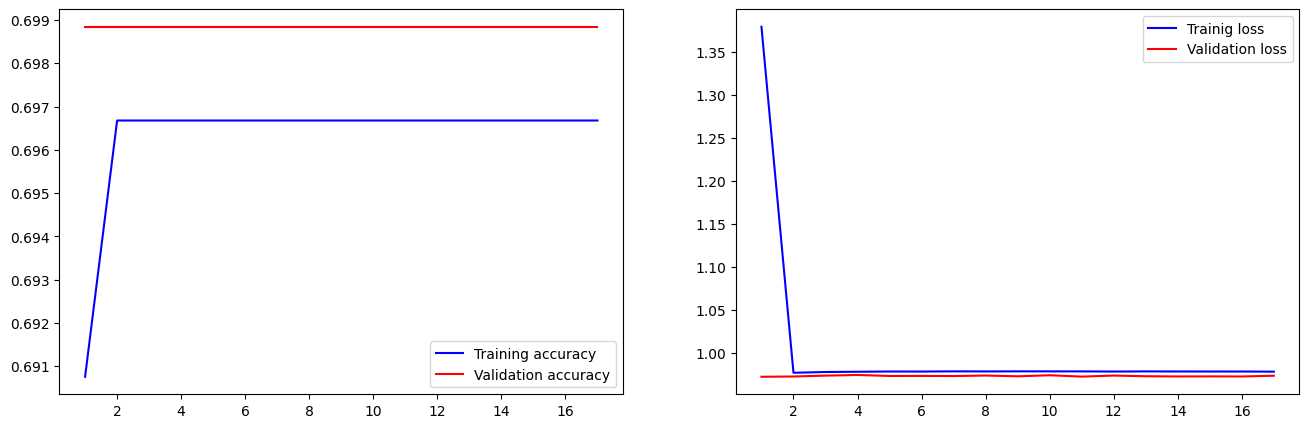

In [22]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label = 'Trainig loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.legend()

plt.show()

In [23]:
y_test = tf.keras.utils.to_categorical(y_test)
print("Evaluate on test data")
results = model_rating.evaluate(X_test, y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
439/439 [==============================] - 69s 122ms/step - loss: 0.9752 - accuracy: 0.6975
test loss, test acc: [0.9752323031425476, 0.697452962398529]
